In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

from coremdlr.utils.base_utils import smooth1D

import lasio
from coremdlr.datasets import strip_config
from striplog import Interval, Striplog

descrips = ['s', 'is', 'ih', 'sh']


def labels_to_striplog(labels, tops, bottoms, component_map=None):
    
    intervals = []
    current_label = labels[0]
    current_top, current_bottom = tops[0], bottoms[0]
    
    for i in range(1, labels.size):
        if labels[i] == current_label:
            current_bottom = bottoms[i]
        else:
            descrip = descrips[current_label]
            interval = Interval(top=current_top, base=current_bottom,
                                description = descrip,
                                components = [strip_config.facies[descrip]])
            intervals.append(interval)
            current_label = labels[i]
            current_top, current_bottom = tops[i], bottoms[i]
    
    interval = Interval(top=current_top, base=bottoms[-1],
                        description = 's',
                        components = strip_config.collapsed_facies[current_label])
    intervals.append(interval)
        
    return Striplog(intervals)


def _make_tick_objects(depths, precision, format_str, tolerance=0.01):
    '''Generate depth tics+locs at given precision.'''
    fmt_fn = lambda x: format_str.format(x)
    ticks = [fmt_fn(depths[0])]
    locs  = [0]
    rmndr = depths % precision
    for i in range(1, rmndr.size-1):
        neighborhood = [rmndr[i-1],rmndr[i],rmndr[i+1]]
        if np.argmin(neighborhood) == 1 and neighborhood[1] < tolerance:
            ticks.append(fmt_fn(depths[i]))
            locs.append(i)
    ticks.append(fmt_fn(depths[-1]))
    locs.append(rmndr.size)
    return ticks, locs
        
    

def plot_preds(dataset, well_name, figsize=(15,650), tick_precision=0.1, format_str='{:.2f}',
               ignore_features=[], seperate_logs=True, preds=None, strip_legend=strip_config.legend):
    """Plot data from a well in `dataset`, optionally with predictions.

    Parameters
    ----------
    dataset : coremdlr.datasets.FacieDataset instance
    well_name : str
        Name of well to plot. Must be present in `dataset`.
    fig_size : tuple(int), optional
        Size of returned matplotlib figure, default=(15,650).
    tick_precision : float, optional
        Precision of depth ticks on first axis.
    format_str : str, optional
        Format string to use for formatting tick labels.
    ignore_features : list(str), optional
        Names of any features present in dataset that should not be plotted.
    seperate_logs : bool, optional
        If plotting 'logs', whether to use seperate axis for each one.
    preds : np.array, optional
        Predictions plotted to the right of labels, if given. Must have same shape as well.y.
    """
    assert type(dataset) is FaciesDataset, 'dataset must be a FacieDataset instance.'
    if well_name in dataset.well_names:
        well = dataset.wells[dataset.well_names.index(well_name)]
    elif well_name in dataset.test_well_names:
        well = dataset.test_wells[dataset.test_well_names.index(well_name)]
    else:
        raise ValueError('Given `well_name`: {} not present in `dataset`'.format(well_name))

    ''' LATER FOR MORE FEATURES
    use_features = dataset.features.difference(set(ignore_features))
    nfeature_ax = len(use_features)
    if 'logs' in use_features and seperate_logs == True:
        nfeature_ax += len(well.which_logs) - 1
    if preds is not None:
        assert preds.shape == well.y.shape, 'Labels `well.y` and `preds` must have the same shape.'
    nlabel_ax = 1 if preds is None else 2
    '''
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    
    # image axis 
    #ticks, locs = _make_tick_objects(well.X['depth'], tick_precision, format_str)
    #ax[0].yaxis.set_major_locator(ticker.FixedLocator((locs)))
    #ax[0].yaxis.set_major_formatter(ticker.FixedFormatter((ticks)))

    
    min_depth, max_depth = well.tops[0], well.bottoms[-1]
    good_rows = np.logical_and(well._depth > min_depth, well._depth < max_depth)
    ax[0].imshow(well._image[good_rows,...])
    
    # labels axis
    labels_strip = labels_to_striplog(well.y, well.tops, well.bottoms)
    labels_strip.plot(legend=well.legend, ax=ax[1])
    
    # preds axis 
    print(preds)
    preds = np.argmax(preds, axis=0) if preds.ndim > 1 else preds
    assert preds.shape == well.y.shape, 'preds and labels shape must match'
    preds_strip = labels_to_striplog(preds, well.tops, well.bottoms)
    preds_strip.plot(legend=well.legend, ax=ax[2])
    
    return fig

In [33]:
import numpy as np
import scipy as sp
from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

fdset = FaciesDataset(["205-21b-3", "204-24a-6", "204-20-6a"],
                    test_wells=["204-19-6"],
                    features=["pseudoGR"],
                    label_resolution=32*5)

fdset.load_or_generate_data()

Loading Well:  205-21b-3


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/well_loader.py:26: RuntimeWarning: Mean of empty slice
  pseudoGR = np.apply_along_axis(lambda x: np.nanmean(x[x.nonzero()]), 1, uimg)


Feature shapes:  [('depth', (766,)), ('pseudoGR', (766, 160))]
Loading Well:  204-24a-6
Feature shapes:  [('depth', (2597,)), ('pseudoGR', (2597, 160))]
Loading Well:  204-20-6a
Feature shapes:  [('depth', (774,)), ('pseudoGR', (774, 160))]
Loading Well:  204-19-6
Feature shapes:  [('depth', (377,)), ('pseudoGR', (377, 160))]


In [34]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

from scipy.stats import mstats


# for balanced log_loss computation
sample_weights = compute_sample_weight('balanced', fdset.y_test) 

# feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1', 'Chi2', 'p-val']
feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1']

def reduce_function(x):
    feats = []
    x = np.ma.masked_invalid(x)
    x = np.ma.masked_less_equal(x, 0.0)
    feats.append(np.mean(x, axis=-1))
    feats.append(np.median(x, axis=-1))
    feats.append(mstats.hmean(x, axis=-1))
    feats.append(mstats.gmean(x, axis=-1))
    feats.append(np.var(x, axis=-1))
    
    # feats.append(sp.signal.qspline1d(x))
    ideal_fourths = mstats.idealfourths(x, axis=-1)
    feats.append(ideal_fourths[:, 0])
    feats.append(ideal_fourths[:, 1])
    
    print(x.shape)
    
    #normal_test = mstats.normaltest(x, axis=1)
    #feats.append(normal_test[0])
    #feats.append(normal_test[1])
    # kur_test = mstats.kurtosistest(x, axis =-1)
    # feats.append(kurtosistest[:, 0])
    # feats.append(kurtosistest[:, 1])
    
    x_feats = np.array(feats).T
    return x_feats


feat_model_args = {
    # NOTE: key needs to be feature name AND feature must be specified in model_args
    'pseudoGR': {
        'model' : 'LambdaModel',
        'model_args' : {
            'feature' : 'pseudoGR',
            'lambda_fn' : reduce_function
        }
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    xgb_predictor = FeaturePredictor(fdset, 
                                     model_args=model_config, 
                                     feature_model_args=feat_model_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test))

In [35]:
best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=50
)

Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.42739948671867
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4041595745947104
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.39113229106258124
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4288935625616968
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.41567381455251273
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.3985208212413033
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.3983738578990295
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4308779713359866
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.3888271789562023
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.3994745880484515
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.41608008371888083
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4147385662898253
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4164508201738598
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.41523746074045875
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4310952043408183
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4319837667401708
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4014162261288698
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.40884402193926
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.448156944518817
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4047335586548721
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.38979216670826494
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.404005271262734
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.41029420075778267
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4296576360632616
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.42448632985363643
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.41806995060989305
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.41103822288409037
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.41455104263927794
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.43421357137841743
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.41485682460464535
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4218488377819364
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.38560334132623286
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.424547499682509
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.42138480392156863
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4231431833978751
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.40321491029119344
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.39202023904454153
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4252148742506361
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4310734010068882
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.43151195307437845
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.40597204306514567
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4125755068493613
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.40189537780470974
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4153619446396445
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.43564837751235885
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.428259153189027
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.43455664640797875
(377, 160)
Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.3997741904166441
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
(377, 160)
F1 score: 0.4065846686921041
(377, 160)
Training model for feature:  pseudoGR
(4137, 160)
(377, 160)
(377, 160)
F1 score: 0.4124362644034775
(377, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

In [36]:
best_params

{'colsample_bytree': 0.46239341232206516,
 'gamma': 0.21223516841549367,
 'learning_rate': 0.15065028276987713,
 'max_depth': 4.0,
 'n_estimators': 242.0,
 'reg_lambda': 6.187153073660272,
 'subsample': 0.3641229800274667}

Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


(4137, 160)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

(377, 160)
                      precision    recall  f1-score   support

           sandstone       0.74      0.82      0.78       187
clay-prone sandstone       0.00      0.00      0.00        61
      sandy mudstone       0.34      0.61      0.44        56
            mudstone       0.55      0.49      0.52        73

         avg / total       0.52      0.59      0.55       377

Total accuracy Score :  0.5941644562334217
Confusion Matrix: 
 [[154   2  18  13]
 [ 36   0  20   5]
 [ 10   1  34  11]
 [  9   1  27  36]]
(377, 160)
[3 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 0 0 0 0 2 0 0 0 0 0 2 2 3 3 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 3 3 2 2 2 2 2 3 3 2
 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 3 0 0 3 0 0 1 0 0 0 0 0 0 3 2 2 0 0
 0 0 3 2 0 0 2 0 2 2 2 2 2 2 0 2 2 2 2 2 3 2 3 3 2 2 2 3 0 3 0 0 0 0 0 0 2
 2 3 2 3 3 3 0 3 2 2 2 2 0 3 2 0 2 0 0 3 0 0 0 0 0 0 2 2 0 0 0 0 3 2 2 2 2
 0 0 0 2 0 2 3 2 0 0 3 0 0 0 2 2 0 3 0 3 3 2 3 2 2 0 2 3 2 0 0 0 2 1 3 2 0
 0 0 0 3 3 3 

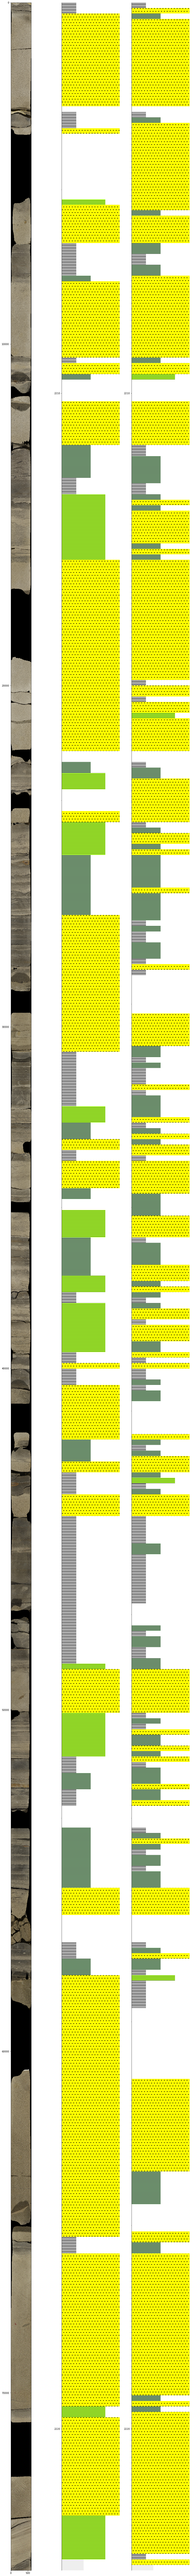

In [44]:
params = {**XGB_SEARCH_SPACE, **best_params, **{'max_depth': 4, 'n_estimators': 242}}
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=feat_model_args)
xgb_predictor.fit(fdset, verbose=True)

y_pred = xgb_predictor.predict(fdset.test_wells[0].X['pseudoGR'])

plot_preds(fdset, "204-19-6", figsize=(15,200), preds=y_pred)

plt.show()
#plt.savefig('foo.pdf')